In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim 
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def one_hot_encode(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes)

# Define the data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(degrees=10),  # Randomly rotate the image by up to 10 degrees
    transforms.GaussianBlur(kernel_size=3),  # Apply random Gaussian blur
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image pixel values
])

# Define the root directory of your dataset
data_root = "/kaggle/input/bird-data-1/Birds_25"

# Create ImageFolder datasets for train, test, and val
train_dataset = ImageFolder(root=data_root + '/train', transform=transform)
val_dataset = ImageFolder(root=data_root + '/val', transform=transform)
test_dataset = ImageFolder(root=data_root + '/test', transform=transform)

# Create DataLoaders for train, val, and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize a dictionary to store one-hot encoded labels for each folder (class)
class_labels_dict = {class_label: [] for class_label in train_dataset.classes}

# Iterate through the DataLoader for demonstration purposes
for data, labels in train_loader:
    one_hot_labels = one_hot_encode(labels, num_classes=25)  # Assuming 25 classes
    
    # Organize one-hot encoded labels into the dictionary
    for class_label, one_hot_label in zip(labels, one_hot_labels):
        class_labels_dict[train_dataset.classes[class_label]].append(one_hot_label)

# # Print or visualize the one-hot encoded labels for each folder (class)
# for class_label, one_hot_labels in class_labels_dict.items():
#     print(f"Class: {class_label}")
#     for i, label in enumerate(one_hot_labels):
#         print(f"Image {i + 1} - One-hot label: {label}")

In [2]:
def class_to_one_hot(class_indices, num_classes):
    return torch.eye(num_classes)[class_indices]
import torch.optim as optim 
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 2
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=16, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=32, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=64, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((8,8))
        self.fc = nn.Linear(128 * 8*8, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 2:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * 2),
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * 2

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet1(img_channel=3, num_classes=25):
    return ResNet(Block, [2,2,2], img_channel, num_classes)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE= 32
model = ResNet1(img_channel=3, num_classes=25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

cuda


In [8]:
print("Using", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 1 GPUs!


In [9]:
# Set the number of epochs
num_epochs = 50
train_losses = []
train_accuracies = []
train_micro_f1_scores = []
train_macro_f1_scores = []
val_losses = []
val_accuracies = []
val_micro_f1_scores = []
val_macro_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    all_labels = []
    all_predictions = []

    # Training
    for data, labels in tqdm(train_loader, desc=f'Training - Epoch {epoch + 1}/{num_epochs}', leave=False):
        x = data.to(device)
        y = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        y_hat = model(x)

        # Compute the loss
        loss = criterion(y_hat, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Record predictions for calculating metrics
        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(torch.argmax(y_hat, dim=1).cpu().numpy())

    average_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    
    print(f"Train - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}")

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    train_micro_f1_scores.append(micro_f1)
    train_macro_f1_scores.append(macro_f1)

    # Validation
    model.eval()
    val_running_loss = 0
    val_all_labels = []
    val_all_predictions = []

    with torch.no_grad():
        for val_data, val_labels in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}/{num_epochs}', leave=False):
            val_x = val_data.to(device)
            val_y = val_labels.to(device)

            val_y_hat = model(val_x)
            val_loss = criterion(val_y_hat, val_y)

            val_running_loss += val_loss.item()

            val_all_labels.extend(val_y.cpu().numpy())
            val_all_predictions.extend(torch.argmax(val_y_hat, dim=1).cpu().numpy())

    val_average_loss = val_running_loss / len(val_loader)
    val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
    val_micro_f1 = f1_score(val_all_labels, val_all_predictions, average='micro')
    val_macro_f1 = f1_score(val_all_labels, val_all_predictions, average='macro')

    print(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_average_loss:.4f}, Accuracy: {val_accuracy:.4f}, Micro F1: {val_micro_f1:.4f}, Macro F1: {val_macro_f1:.4f}")

    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)
    val_micro_f1_scores.append(val_micro_f1)
    val_macro_f1_scores.append(val_macro_f1)

    # Save model checkpoint if needed
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'micro_f1': train_micro_f1_scores,
        'macro_f1': train_macro_f1_scores,
        'accuracies': train_accuracies,
        'val_micro_f1': val_micro_f1_scores,
        'val_macro_f1': val_macro_f1_scores,
        'val_accuracies': val_accuracies,
        # Add other necessary information
    }, '/kaggle/working/model.pth')


Train - Epoch [1/50], Loss: 2.7701, Accuracy: 0.1625, Micro F1: 0.1625, Macro F1: 0.1584


Validation - Epoch [1/50], Loss: 2.6303, Accuracy: 0.2060, Micro F1: 0.2060, Macro F1: 0.1709


Train - Epoch [2/50], Loss: 2.3917, Accuracy: 0.2751, Micro F1: 0.2751, Macro F1: 0.2681


Validation - Epoch [2/50], Loss: 2.9210, Accuracy: 0.2052, Micro F1: 0.2052, Macro F1: 0.1665


Train - Epoch [3/50], Loss: 2.2072, Accuracy: 0.3281, Micro F1: 0.3281, Macro F1: 0.3220


Validation - Epoch [3/50], Loss: 3.0448, Accuracy: 0.2425, Micro F1: 0.2425, Macro F1: 0.2067


Train - Epoch [4/50], Loss: 2.0814, Accuracy: 0.3680, Micro F1: 0.3680, Macro F1: 0.3627


Validation - Epoch [4/50], Loss: 2.1079, Accuracy: 0.3561, Micro F1: 0.3561, Macro F1: 0.3396


Train - Epoch [5/50], Loss: 1.9790, Accuracy: 0.3995, Micro F1: 0.3995, Macro F1: 0.3955


Validation - Epoch [5/50], Loss: 2.1312, Accuracy: 0.3457, Micro F1: 0.3457, Macro F1: 0.3447


Train - Epoch [6/50], Loss: 1.8931, Accuracy: 0.4246, Micro F1: 0.4246, Macro F1: 0.4213


Validation - Epoch [6/50], Loss: 1.8668, Accuracy: 0.4300, Micro F1: 0.4300, Macro F1: 0.4194


Train - Epoch [7/50], Loss: 1.8216, Accuracy: 0.4469, Micro F1: 0.4469, Macro F1: 0.4437


Validation - Epoch [7/50], Loss: 1.8204, Accuracy: 0.4341, Micro F1: 0.4341, Macro F1: 0.4251


Train - Epoch [8/50], Loss: 1.7769, Accuracy: 0.4632, Micro F1: 0.4632, Macro F1: 0.4611


Validation - Epoch [8/50], Loss: 1.8506, Accuracy: 0.4330, Micro F1: 0.4330, Macro F1: 0.4331


Train - Epoch [9/50], Loss: 1.7249, Accuracy: 0.4773, Micro F1: 0.4773, Macro F1: 0.4753


Validation - Epoch [9/50], Loss: 1.7376, Accuracy: 0.4714, Micro F1: 0.4714, Macro F1: 0.4623


Train - Epoch [10/50], Loss: 1.6690, Accuracy: 0.4950, Micro F1: 0.4950, Macro F1: 0.4932


Validation - Epoch [10/50], Loss: 1.6955, Accuracy: 0.4882, Micro F1: 0.4882, Macro F1: 0.4924


Train - Epoch [11/50], Loss: 1.6333, Accuracy: 0.5062, Micro F1: 0.5062, Macro F1: 0.5043


Validation - Epoch [11/50], Loss: 1.6179, Accuracy: 0.5108, Micro F1: 0.5108, Macro F1: 0.5086


Train - Epoch [12/50], Loss: 1.6007, Accuracy: 0.5137, Micro F1: 0.5137, Macro F1: 0.5121


Validation - Epoch [12/50], Loss: 1.5948, Accuracy: 0.5186, Micro F1: 0.5186, Macro F1: 0.5188


Train - Epoch [13/50], Loss: 1.5705, Accuracy: 0.5217, Micro F1: 0.5217, Macro F1: 0.5203


Validation - Epoch [13/50], Loss: 1.5907, Accuracy: 0.5161, Micro F1: 0.5161, Macro F1: 0.5150


Train - Epoch [14/50], Loss: 1.5345, Accuracy: 0.5355, Micro F1: 0.5355, Macro F1: 0.5343


Validation - Epoch [14/50], Loss: 1.6633, Accuracy: 0.5108, Micro F1: 0.5108, Macro F1: 0.5057


Train - Epoch [15/50], Loss: 1.5115, Accuracy: 0.5410, Micro F1: 0.5410, Macro F1: 0.5398


Validation - Epoch [15/50], Loss: 1.5645, Accuracy: 0.5314, Micro F1: 0.5314, Macro F1: 0.5280


Train - Epoch [16/50], Loss: 1.4767, Accuracy: 0.5508, Micro F1: 0.5508, Macro F1: 0.5498


Validation - Epoch [16/50], Loss: 1.4964, Accuracy: 0.5366, Micro F1: 0.5366, Macro F1: 0.5386


Train - Epoch [17/50], Loss: 1.4564, Accuracy: 0.5609, Micro F1: 0.5609, Macro F1: 0.5600


Validation - Epoch [17/50], Loss: 1.5050, Accuracy: 0.5370, Micro F1: 0.5370, Macro F1: 0.5385


Train - Epoch [18/50], Loss: 1.4263, Accuracy: 0.5670, Micro F1: 0.5670, Macro F1: 0.5663


Validation - Epoch [18/50], Loss: 1.4887, Accuracy: 0.5512, Micro F1: 0.5512, Macro F1: 0.5428


Train - Epoch [19/50], Loss: 1.4044, Accuracy: 0.5736, Micro F1: 0.5736, Macro F1: 0.5728


Validation - Epoch [19/50], Loss: 1.9140, Accuracy: 0.4448, Micro F1: 0.4448, Macro F1: 0.4375


Train - Epoch [20/50], Loss: 1.3772, Accuracy: 0.5808, Micro F1: 0.5808, Macro F1: 0.5803


Validation - Epoch [20/50], Loss: 1.4477, Accuracy: 0.5678, Micro F1: 0.5678, Macro F1: 0.5698


Train - Epoch [21/50], Loss: 1.3648, Accuracy: 0.5887, Micro F1: 0.5887, Macro F1: 0.5883


Validation - Epoch [21/50], Loss: 1.4484, Accuracy: 0.5609, Micro F1: 0.5609, Macro F1: 0.5664


Train - Epoch [22/50], Loss: 1.3452, Accuracy: 0.5940, Micro F1: 0.5940, Macro F1: 0.5935


Validation - Epoch [22/50], Loss: 1.8329, Accuracy: 0.4929, Micro F1: 0.4929, Macro F1: 0.4909


Train - Epoch [23/50], Loss: 1.3221, Accuracy: 0.5987, Micro F1: 0.5987, Macro F1: 0.5983


Validation - Epoch [23/50], Loss: 1.3528, Accuracy: 0.5902, Micro F1: 0.5902, Macro F1: 0.5887


Train - Epoch [24/50], Loss: 1.2982, Accuracy: 0.6049, Micro F1: 0.6049, Macro F1: 0.6047


Validation - Epoch [24/50], Loss: 1.2930, Accuracy: 0.6018, Micro F1: 0.6018, Macro F1: 0.6022


Train - Epoch [25/50], Loss: 1.2847, Accuracy: 0.6104, Micro F1: 0.6104, Macro F1: 0.6101


Validation - Epoch [25/50], Loss: 1.2789, Accuracy: 0.6066, Micro F1: 0.6066, Macro F1: 0.6076


Train - Epoch [26/50], Loss: 1.2612, Accuracy: 0.6199, Micro F1: 0.6199, Macro F1: 0.6197


Validation - Epoch [26/50], Loss: 1.2700, Accuracy: 0.6175, Micro F1: 0.6175, Macro F1: 0.6181


Train - Epoch [27/50], Loss: 1.2483, Accuracy: 0.6224, Micro F1: 0.6224, Macro F1: 0.6223


Validation - Epoch [27/50], Loss: 1.3710, Accuracy: 0.5859, Micro F1: 0.5859, Macro F1: 0.5863


Train - Epoch [28/50], Loss: 1.2306, Accuracy: 0.6260, Micro F1: 0.6260, Macro F1: 0.6257


Validation - Epoch [28/50], Loss: 1.1947, Accuracy: 0.6365, Micro F1: 0.6365, Macro F1: 0.6366


Train - Epoch [29/50], Loss: 1.2117, Accuracy: 0.6299, Micro F1: 0.6299, Macro F1: 0.6298


Validation - Epoch [29/50], Loss: 1.2662, Accuracy: 0.6186, Micro F1: 0.6186, Macro F1: 0.6180


Train - Epoch [30/50], Loss: 1.1960, Accuracy: 0.6388, Micro F1: 0.6388, Macro F1: 0.6387


Validation - Epoch [30/50], Loss: 1.2641, Accuracy: 0.6151, Micro F1: 0.6151, Macro F1: 0.6119


Train - Epoch [31/50], Loss: 1.1808, Accuracy: 0.6436, Micro F1: 0.6436, Macro F1: 0.6436


Validation - Epoch [31/50], Loss: 1.2890, Accuracy: 0.6207, Micro F1: 0.6207, Macro F1: 0.6225


Train - Epoch [32/50], Loss: 1.1665, Accuracy: 0.6482, Micro F1: 0.6482, Macro F1: 0.6481


Validation - Epoch [32/50], Loss: 1.2261, Accuracy: 0.6297, Micro F1: 0.6297, Macro F1: 0.6266


Train - Epoch [33/50], Loss: 1.1498, Accuracy: 0.6502, Micro F1: 0.6502, Macro F1: 0.6503


Validation - Epoch [33/50], Loss: 1.1293, Accuracy: 0.6508, Micro F1: 0.6508, Macro F1: 0.6509


Train - Epoch [34/50], Loss: 1.1302, Accuracy: 0.6573, Micro F1: 0.6573, Macro F1: 0.6574


Validation - Epoch [34/50], Loss: 1.1565, Accuracy: 0.6469, Micro F1: 0.6469, Macro F1: 0.6444


Train - Epoch [35/50], Loss: 1.1188, Accuracy: 0.6609, Micro F1: 0.6609, Macro F1: 0.6608


Validation - Epoch [35/50], Loss: 1.2276, Accuracy: 0.6291, Micro F1: 0.6291, Macro F1: 0.6307


Train - Epoch [36/50], Loss: 1.1046, Accuracy: 0.6637, Micro F1: 0.6637, Macro F1: 0.6637


Validation - Epoch [36/50], Loss: 1.2156, Accuracy: 0.6332, Micro F1: 0.6332, Macro F1: 0.6382


Train - Epoch [37/50], Loss: 1.0973, Accuracy: 0.6670, Micro F1: 0.6670, Macro F1: 0.6671


Validation - Epoch [37/50], Loss: 1.2008, Accuracy: 0.6429, Micro F1: 0.6429, Macro F1: 0.6461


Train - Epoch [38/50], Loss: 1.0777, Accuracy: 0.6754, Micro F1: 0.6754, Macro F1: 0.6756


Validation - Epoch [38/50], Loss: 1.1038, Accuracy: 0.6691, Micro F1: 0.6691, Macro F1: 0.6679


Train - Epoch [39/50], Loss: 1.0571, Accuracy: 0.6798, Micro F1: 0.6798, Macro F1: 0.6800


Validation - Epoch [39/50], Loss: 1.1730, Accuracy: 0.6457, Micro F1: 0.6457, Macro F1: 0.6483


Train - Epoch [40/50], Loss: 1.0494, Accuracy: 0.6830, Micro F1: 0.6830, Macro F1: 0.6832


Validation - Epoch [40/50], Loss: 1.0929, Accuracy: 0.6628, Micro F1: 0.6628, Macro F1: 0.6626


Train - Epoch [41/50], Loss: 1.0418, Accuracy: 0.6851, Micro F1: 0.6851, Macro F1: 0.6854


Validation - Epoch [41/50], Loss: 1.2556, Accuracy: 0.6332, Micro F1: 0.6332, Macro F1: 0.6329


Train - Epoch [42/50], Loss: 1.0191, Accuracy: 0.6920, Micro F1: 0.6920, Macro F1: 0.6921


Validation - Epoch [42/50], Loss: 1.1435, Accuracy: 0.6561, Micro F1: 0.6561, Macro F1: 0.6602


Train - Epoch [43/50], Loss: 1.0174, Accuracy: 0.6919, Micro F1: 0.6919, Macro F1: 0.6919


Validation - Epoch [43/50], Loss: 1.0126, Accuracy: 0.6912, Micro F1: 0.6912, Macro F1: 0.6938


Train - Epoch [44/50], Loss: 0.9905, Accuracy: 0.6991, Micro F1: 0.6991, Macro F1: 0.6992


Validation - Epoch [44/50], Loss: 1.0491, Accuracy: 0.6848, Micro F1: 0.6848, Macro F1: 0.6865


Train - Epoch [45/50], Loss: 0.9850, Accuracy: 0.7043, Micro F1: 0.7043, Macro F1: 0.7044


Validation - Epoch [45/50], Loss: 1.0966, Accuracy: 0.6618, Micro F1: 0.6618, Macro F1: 0.6740


Train - Epoch [46/50], Loss: 0.9814, Accuracy: 0.7058, Micro F1: 0.7058, Macro F1: 0.7059


Validation - Epoch [46/50], Loss: 1.0046, Accuracy: 0.6957, Micro F1: 0.6957, Macro F1: 0.6967


Train - Epoch [47/50], Loss: 0.9661, Accuracy: 0.7083, Micro F1: 0.7083, Macro F1: 0.7087


Validation - Epoch [47/50], Loss: 1.4362, Accuracy: 0.5993, Micro F1: 0.5993, Macro F1: 0.5969


Train - Epoch [48/50], Loss: 0.9510, Accuracy: 0.7151, Micro F1: 0.7151, Macro F1: 0.7154


Validation - Epoch [48/50], Loss: 0.9920, Accuracy: 0.6988, Micro F1: 0.6988, Macro F1: 0.6976


Train - Epoch [49/50], Loss: 0.9396, Accuracy: 0.7158, Micro F1: 0.7158, Macro F1: 0.7161


Validation - Epoch [49/50], Loss: 2.1423, Accuracy: 0.5204, Micro F1: 0.5204, Macro F1: 0.5400


Train - Epoch [50/50], Loss: 0.9297, Accuracy: 0.7197, Micro F1: 0.7197, Macro F1: 0.7199


Validation - Epoch [50/50], Loss: 1.1017, Accuracy: 0.6586, Micro F1: 0.6586, Macro F1: 0.6671


In [ ]:
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'micro_f1': train_micro_f1_scores,
#         'macro_f1': train_macro_f1_scores,
#         'accuracies': train_accuracies,
#         'val_micro_f1': val_micro_f1_scores,
#         'val_macro_f1': val_macro_f1_scores,
#         'val_accuracies': val_accuracies,
#         # Add other necessary information
#     }, '/kaggle/working/model.pth')

In [11]:
import numpy as np

In [12]:
# Assuming you have a test_loader for your test dataset

model.eval()  # Set the model to evaluation mode

all_test_labels = []
all_predictions = []

with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc='Inference on Test Set', leave=False):
        test_x = test_data.to(device)
        test_y = test_labels.to(device)

        # Forward pass
        test_y_hat = model(test_x)

        # Record predictions for comparison
        all_test_labels.extend(test_y.cpu().numpy())
        all_predictions.extend(torch.argmax(test_y_hat, dim=1).cpu().numpy())

# Convert the labels and predictions to numpy arrays
all_test_labels = np.array(all_test_labels)
all_predictions = np.array(all_predictions)

# Display actual and predicted values
for i in range(len(all_test_labels)):
    print(f"Sample {i + 1}: Actual - {all_test_labels[i]}, Predicted - {all_predictions[i]}")

Sample 1: Actual - 0, Predicted - 5
Sample 2: Actual - 0, Predicted - 0
Sample 3: Actual - 0, Predicted - 0
Sample 4: Actual - 0, Predicted - 0
Sample 5: Actual - 0, Predicted - 6
Sample 6: Actual - 0, Predicted - 0
Sample 7: Actual - 0, Predicted - 6
Sample 8: Actual - 0, Predicted - 13
Sample 9: Actual - 0, Predicted - 0
Sample 10: Actual - 0, Predicted - 0
Sample 11: Actual - 0, Predicted - 2
Sample 12: Actual - 0, Predicted - 0
Sample 13: Actual - 0, Predicted - 0
Sample 14: Actual - 0, Predicted - 6
Sample 15: Actual - 0, Predicted - 5
Sample 16: Actual - 0, Predicted - 0
Sample 17: Actual - 0, Predicted - 0
Sample 18: Actual - 0, Predicted - 0
Sample 19: Actual - 0, Predicted - 0
Sample 20: Actual - 0, Predicted - 15
Sample 21: Actual - 0, Predicted - 0
Sample 22: Actual - 0, Predicted - 21
Sample 23: Actual - 0, Predicted - 9
Sample 24: Actual - 0, Predicted - 14
Sample 25: Actual - 0, Predicted - 0
Sample 26: Actual - 0, Predicted - 0
Sample 27: Actual - 0, Predicted - 0
Sample

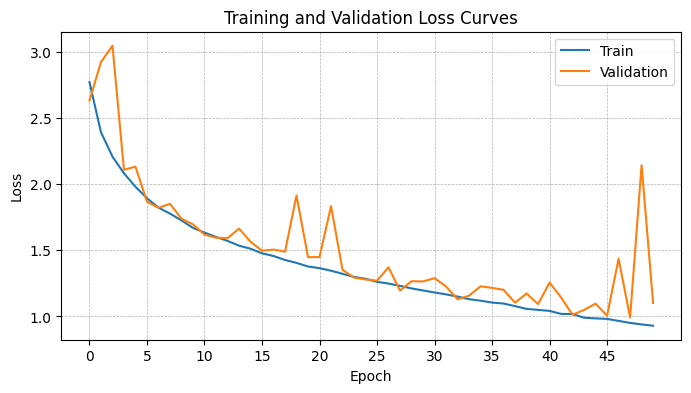

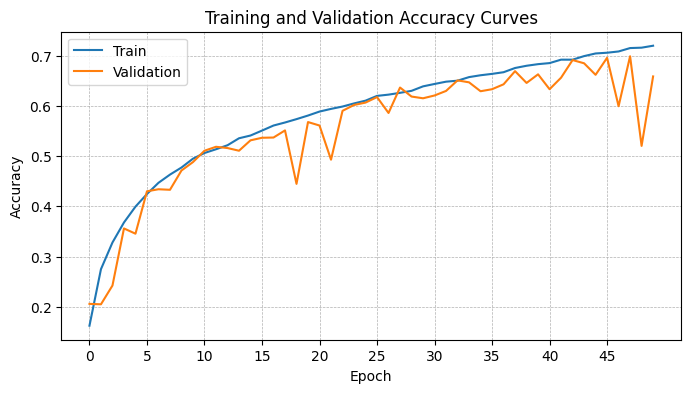

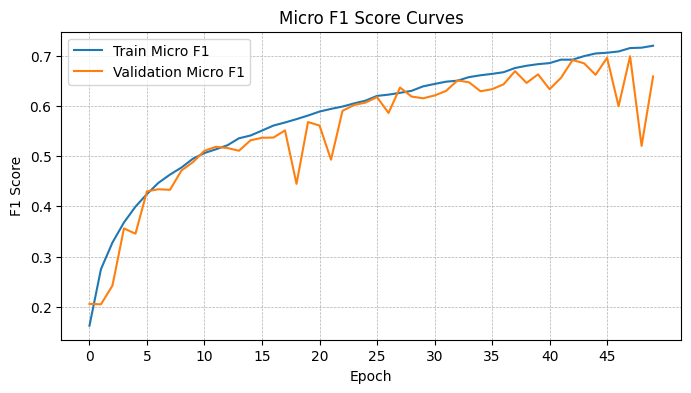

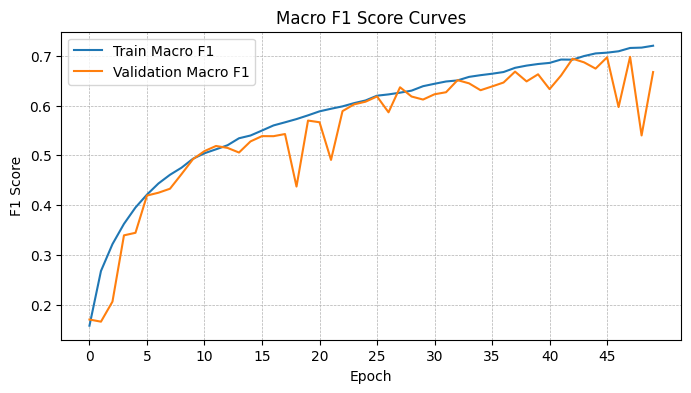

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot and add gridlines
def plot_with_grid(x, train_data, val_data, train_label, val_label, xlabel, ylabel, title, x_interval=5):
    plt.figure(figsize=(8, 4))
    plt.plot(x, train_data, label=train_label)
    plt.plot(x, val_data, label=val_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(np.arange(min(x), max(x)+1, x_interval))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Training Loss
plot_with_grid(range(len(train_losses)), train_losses, val_losses, 'Train', 'Validation', 'Epoch', 'Loss', 'Training and Validation Loss Curves')

# Training Accuracy
plot_with_grid(range(len(train_accuracies)), train_accuracies, val_accuracies, 'Train', 'Validation', 'Epoch', 'Accuracy', 'Training and Validation Accuracy Curves')

# Micro F1 Scores
plot_with_grid(range(len(train_micro_f1_scores)), train_micro_f1_scores, val_micro_f1_scores, 'Train Micro F1', 'Validation Micro F1', 'Epoch', 'F1 Score', 'Micro F1 Score Curves')

# Macro F1 Scores
plot_with_grid(range(len(train_macro_f1_scores)), train_macro_f1_scores, val_macro_f1_scores, 'Train Macro F1', 'Validation Macro F1', 'Epoch', 'F1 Score', 'Macro F1 Score Curves')


In [17]:
import csv

# Load the saved model
checkpoint = torch.load('/kaggle/working/model.pth')

# Extract necessary information
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
micro_f1 = checkpoint['micro_f1']
macro_f1 = checkpoint['macro_f1']
accuracies = checkpoint['accuracies']

val_micro_f1 = checkpoint['val_micro_f1']
val_macro_f1 = checkpoint['val_macro_f1']
val_accuracies = checkpoint['val_accuracies']

# Add other necessary information as needed

# Create a CSV file and write the information to different columns
csv_file_path = '/kaggle/working/model_info.csv'
header = ['Epoch', 'Model State Dict', 'Optimizer State Dict', 'Micro F1', 'Macro F1', 'Accuracies', 'Val Micro F1', 'Val Macro F1', 'Val Accuracies']  # Add other header names as needed

with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header
    writer.writerow(header)

    # Write the data
    for epoch, (micro_f1_val, macro_f1_val, accuracy_val) in enumerate(zip(val_micro_f1, val_macro_f1, val_accuracies), start=1):
        writer.writerow([epoch, model_state_dict, optimizer_state_dict, micro_f1[epoch - 1], macro_f1[epoch - 1], accuracies[epoch - 1], micro_f1_val, macro_f1_val, accuracy_val])
        # Add other data as needed
